In [103]:
%matplotlib inline
from os.path import join
import pandas as pd
import skbio
import matplotlib.pyplot as plt
from skbio.stats import ordination
import seaborn as sns
from skbio.stats.distance import permanova

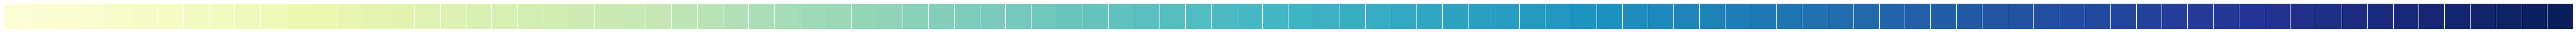

In [104]:
sns.palplot(sns.color_palette("YlGnBu", 100))
colors = sns.color_palette("YlGnBu", 100)

In [105]:
def filter_dm_and_map(dm, map_df):
    ids_to_exclude = set(dm.ids) - set(map_df.index.values)
    ids_to_keep = set(dm.ids) - ids_to_exclude
    filtered_dm = dm.filter(ids_to_keep)
    filtered_map = map_df.loc[ids_to_keep]

    return filtered_dm, filtered_map

In [106]:
home = '/home/office-microbe-files'
map_fp = join(home, 'master_map_150908.txt')
sample_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
sample_md = sample_md[sample_md['16SITS'] == '16S']
sample_md = sample_md[sample_md['OfficeSample'] == 'yes']
sample_md['Meta'] = sample_md.Description.apply(lambda x: '.'.join(x.split('.')[:3]))


In [107]:
uw_dm = skbio.DistanceMatrix.read(join(home, 'core_div_97/bdiv_even1000/unweighted_unifrac_dm.txt'))
w_dm = skbio.DistanceMatrix.read(join(home, 'core_div_97/bdiv_even1000/weighted_unifrac_dm.txt'))

In [108]:
dist_mat = w_dm

In [109]:
alpha_div_fp = '/home/office-microbe-files/core_div_out/arare_max1000/alpha_div_collated/PD_whole_tree.txt'
alpha_div = pd.read_csv(alpha_div_fp, sep='\t', index_col=0)
alpha_div = alpha_div.T.drop(['sequences per sample', 'iteration'])
alpha_cols = [e for e in alpha_div.columns if '1000' in e]
alpha_div = alpha_div[alpha_cols]

In [110]:
sample_md = pd.concat([sample_md, alpha_div], axis=1, join='inner')
sample_md['MeanAlpha'] = sample_md[alpha_cols].mean(axis=1)

#Plot all samples colored by run and season
##Filter out all replicates and blanks


In [111]:
replicate_ids = '''F2F.2.Ce.021
F2F.2.Ce.022
F2F.3.Ce.021
F2F.3.Ce.022
F2W.2.Ca.021
F2W.2.Ca.022
F2W.2.Ce.021
F2W.2.Ce.022
F3W.2.Ce.021
F3W.2.Ce.022
F1F.3.Ca.021
F1F.3.Ca.022
F1C.3.Ca.021
F1C.3.Ca.022
F1W.2.Ce.021
F1W.2.Ce.022
F1W.3.Dr.021
F1W.3.Dr.022
F1C.3.Dr.021
F1C.3.Dr.022
F2W.3.Dr.059
F3F.2.Ce.078'''.split('\n')

In [112]:
reps = sample_md[sample_md['Description'].isin(replicate_ids)]
reps = reps.drop(reps.drop_duplicates('Description').index).index
filt_md = sample_md.drop(reps, inplace=False)

Filter distance matrix and map to match each other

In [113]:
filt_dm, filt_md = filter_dm_and_map(dist_mat, filt_md)

Calculate pcoa

In [114]:
filt_pcoa = ordination.pcoa(filt_dm)

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:102: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.4146469741396162 and the largest is 89.87160848302909.
  RuntimeWarning


###add pcoa to mapping file

In [115]:
filt_md.loc[:, 'PC1'] = filt_pcoa.samples.loc[filt_md.index, 'PC1']
filt_md.loc[:, 'PC2'] = filt_pcoa.samples.loc[filt_md.index, 'PC2']
filt_md.loc[:, 'PC3'] = filt_pcoa.samples.loc[filt_md.index, 'PC3']

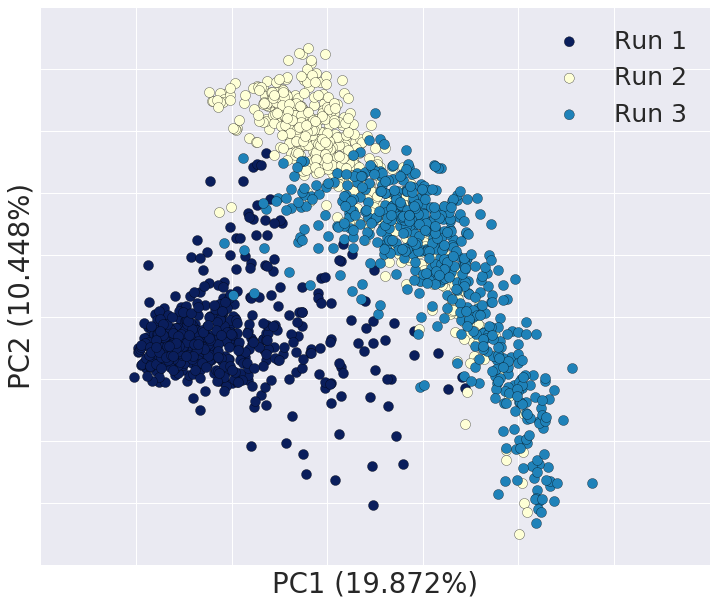

In [116]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    
    fig, ax = plt.subplots(1, 1)    
    fig.set_size_inches(12, 10)
    groups = filt_md.groupby('Run')
    vals = [99, 0, 66, 33]
    c = 0
    x = 'PC1'
    y = 'PC2'

    for name, group in groups:
        ax.scatter(group[x], group[y], label=name, c=colors[vals[c]], s=100)
        c += 1
    ax.legend(['Run 1', 'Run 2', 'Run 3'], loc='best')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    
    ax.set_xlabel('{pc} ({num:.{digits}f}%)'.format(pc=x, num=filt_pcoa.proportion_explained[x]*100, digits=3))
    ax.set_ylabel('{pc} ({num:.{digits}f}%)'.format(pc=y, num=filt_pcoa.proportion_explained[y]*100, digits=3))
plt.savefig('all_samples_run_weighted.svg', dpi=300)

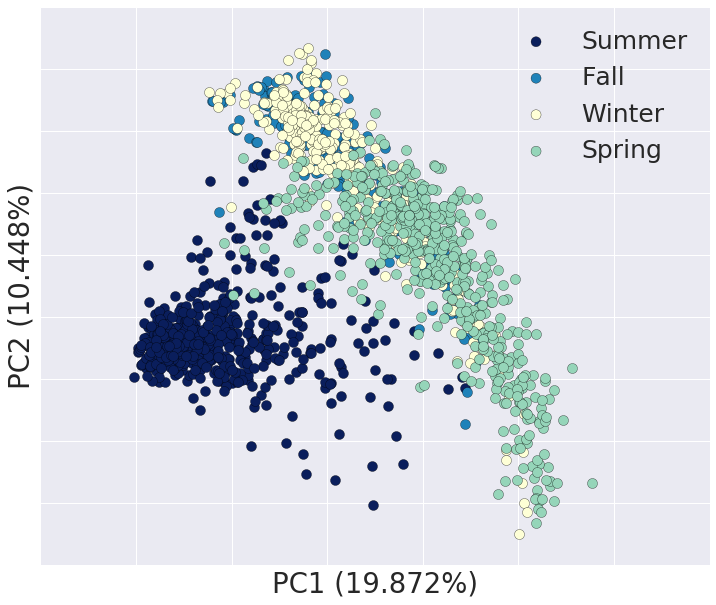

In [117]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    
    fig, ax = plt.subplots(1, 1)    
    fig.set_size_inches(12, 10)
    groups = filt_md.groupby('Period')
    vals = [99, 66, 0, 33]
    c = 0
    x = 'PC1'
    y = 'PC2'
    alphas = [1, 1, .3, 1]
    for name, group in groups:
        ax.scatter(group[x], group[y], label=name, c=colors[vals[c]], s=100)
        c += 1
    ax.legend(['Summer', 'Fall', 'Winter', 'Spring'], loc='best')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xlabel('{pc} ({num:.{digits}f}%)'.format(pc=x, num=filt_pcoa.proportion_explained[x]*100, digits=3))
    ax.set_ylabel('{pc} ({num:.{digits}f}%)'.format(pc=y, num=filt_pcoa.proportion_explained[y]*100, digits=3))
plt.savefig('all_samples_season_weighted.svg', dpi=300)

We need 4 pcoa plots

1. Plot all samples except for replicates and blanks colored by season
2. Plot all samples except for replicates and blanks colored by Run
3. Plot samples that were from the same season, but different runs. 
4. Plot different seasons but on the same runs.  

In [118]:
run_4_md = sample_md[(sample_md['Run'] == '4')].copy()

In [119]:
run_4_md = run_4_md[(run_4_md.Meta.duplicated(keep='first')) | run_4_md.Meta.duplicated(keep='last')]

In [120]:
run_4_dm, run_4_md = filter_dm_and_map(dist_mat, run_4_md)
run_4_pcoa = ordination.pcoa(run_4_dm)

In [121]:
run_4_md.loc[:, 'PC1'] = run_4_pcoa.samples.loc[run_4_md.index, 'PC1']
run_4_md.loc[:, 'PC2'] = run_4_pcoa.samples.loc[run_4_md.index, 'PC2']
run_4_md.loc[:, 'PC3'] = run_4_pcoa.samples.loc[run_4_md.index, 'PC3']

In [122]:
def midpoint(x, y):
    return ((x[0] + x[1])/2, (y[0] + y[1])/2)

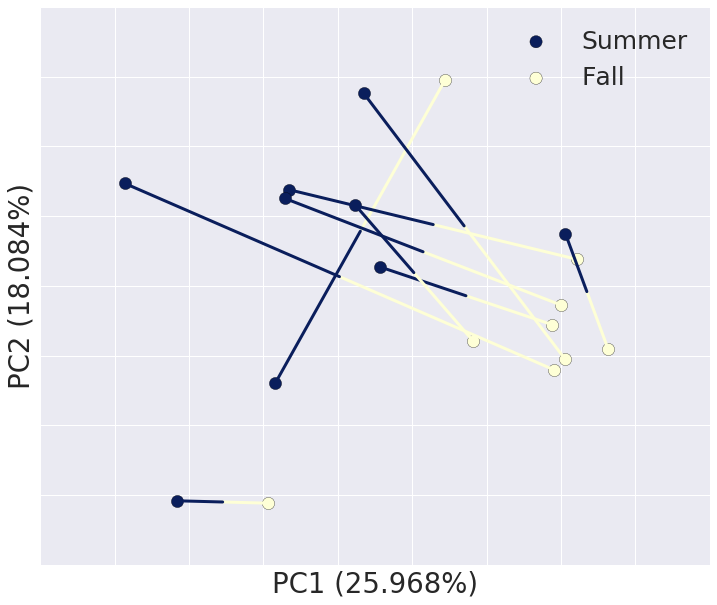

In [123]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    
    fig, ax = plt.subplots(1, 1)    
    fig.set_size_inches(12, 10)
    groups = run_4_md.groupby('Period')
    vals = [99, 0, 0, 33]
    c = 0
    x = 'PC1'
    y = 'PC2'
    for name, group in groups:
        ax.scatter(group[x], group[y], label=name, c=colors[vals[c]], s=150)
        c += 1
    ax.legend(['Summer', 'Fall'], loc='best')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xlabel('{pc} ({num:.{digits}f}%)'.format(pc=x, num=run_4_pcoa.proportion_explained[x]*100, digits=3))
    ax.set_ylabel('{pc} ({num:.{digits}f}%)'.format(pc=y, num=run_4_pcoa.proportion_explained[y]*100, digits=3))
#To get rid of lines just comment the next few lines out    
    for id_ in run_4_md.Description.apply(lambda x: '.'.join(x.split('.')[:3])).unique():
        x3, y3 = run_4_md[(run_4_md.Meta == id_) & (run_4_md.Period == '1')][[x, y]].values[0]
        x1, y1 = run_4_md[(run_4_md.Meta == id_) & (run_4_md.Period == '2')][[x, y]].values[0]
        x2, y2 = midpoint([x1, x3], [y1, y3])
        ax.plot([x1, x2], [y1, y2], c=colors[0], linewidth=3.0)
        ax.plot([x2, x3], [y2, y3], c=colors[99], linewidth=3.0)
plt.savefig('reps_samples_season_weighted.svg', dpi=300)


In [124]:
per_1_md = sample_md[(sample_md['ProjectID'].isin(replicate_ids)) & (sample_md['Period'] == '1')].copy()

In [125]:
per_1_md = per_1_md[per_1_md.Meta.isin(per_1_md[per_1_md.Run =='3']['Meta'])]

In [126]:
per_1_dm, per_1_md = filter_dm_and_map(dist_mat, per_1_md)
per_1_pcoa = ordination.pcoa(per_1_dm)

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:102: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.013411984612719299 and the largest is 1.674131384224069.
  RuntimeWarning


In [127]:
per_1_md.loc[:, 'PC1'] = per_1_pcoa.samples.loc[per_1_md.index, 'PC1']
per_1_md.loc[:, 'PC2'] = per_1_pcoa.samples.loc[per_1_md.index, 'PC2']
per_1_md.loc[:, 'PC3'] = per_1_pcoa.samples.loc[per_1_md.index, 'PC3']

In [128]:
# per_1_md = per_1_md[per_1_md['PlateLocation'] !='floor']

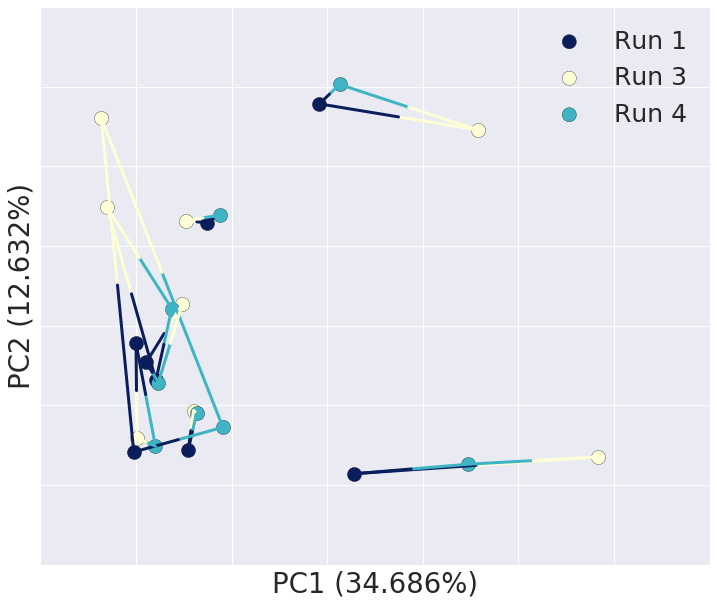

In [129]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    
    fig, ax = plt.subplots(1, 1)    
    fig.set_size_inches(12, 10)
    groups = per_1_md.groupby('Run')
    vals = [99, 0, 50, 33]
    c = 0
    x = 'PC1'
    y = 'PC2'
    for name, group in groups:
        ax.scatter(group[x], group[y], label=name, c=colors[vals[c]], s=200)
        c += 1
    ax.legend(['Run 1', 'Run 3', 'Run 4'], loc='best')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xlabel('{pc} ({num:.{digits}f}%)'.format(pc=x, num=per_1_pcoa.proportion_explained[x]*100, digits=3))
    ax.set_ylabel('{pc} ({num:.{digits}f}%)'.format(pc=y, num=per_1_pcoa.proportion_explained[y]*100, digits=3))
    
    for id_ in per_1_md.Description.apply(lambda x: '.'.join(x.split('.')[:3])).unique():
        x3, y3 = per_1_md[(per_1_md.Meta == id_) & (per_1_md.Run == '1')][[x, y]].values[0]
        x1, y1 = per_1_md[(per_1_md.Meta == id_) & (per_1_md.Run == '3')][[x, y]].values[0]
        x2, y2 = midpoint([x1, x3], [y1, y3])
        ax.plot([x1, x2], [y1, y2], c=colors[0], linewidth=3.0)
        ax.plot([x2, x3], [y2, y3], c=colors[99], linewidth=3.0)
        
    for id_ in per_1_md.Description.apply(lambda x: '.'.join(x.split('.')[:3])).unique():
        x3, y3 = per_1_md[(per_1_md.Meta == id_) & (per_1_md.Run == '1')][[x, y]].values[0]
        x1, y1 = per_1_md[(per_1_md.Meta == id_) & (per_1_md.Run == '4')][[x, y]].values[0]
        x2, y2 = midpoint([x1, x3], [y1, y3])
        ax.plot([x1, x2], [y1, y2], c=colors[50], linewidth=3.0)
        ax.plot([x2, x3], [y2, y3], c=colors[99], linewidth=3.0)

    for id_ in per_1_md.Description.apply(lambda x: '.'.join(x.split('.')[:3])).unique():
        x3, y3 = per_1_md[(per_1_md.Meta == id_) & (per_1_md.Run == '3')][[x, y]].values[0]
        x1, y1 = per_1_md[(per_1_md.Meta == id_) & (per_1_md.Run == '4')][[x, y]].values[0]
        x2, y2 = midpoint([x1, x3], [y1, y3])
        ax.plot([x1, x2], [y1, y2], c=colors[50], linewidth=3.0)
        ax.plot([x2, x3], [y2, y3], c=colors[0], linewidth=3.0)
    
plt.savefig('reps_samples_run_weighted.svg', dpi=300)

    

#Alpha diversity plots

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


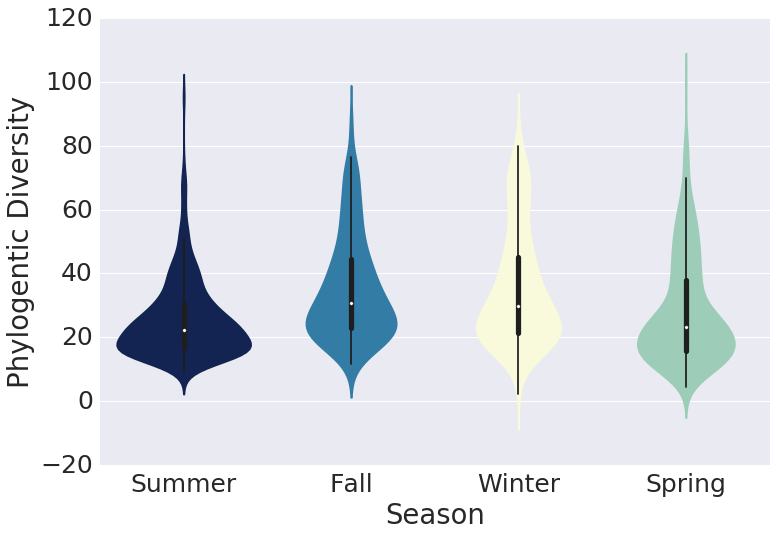

In [28]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    plt.figure(figsize=(12, 8))
    ax = sns.violinplot(x="Period", y="MeanAlpha", data=filt_md.sort("Period"), palette= [colors[e] for e in [99, 66, 0, 33]])
    ax.set_xticklabels(['Summer', 'Fall', 'Winter', 'Spring'])
    ax.set_xlabel('Season')
    ax.set_ylabel('Phylogentic Diversity')
plt.savefig('all_samples_season_alpha.svg', dpi=300)



/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


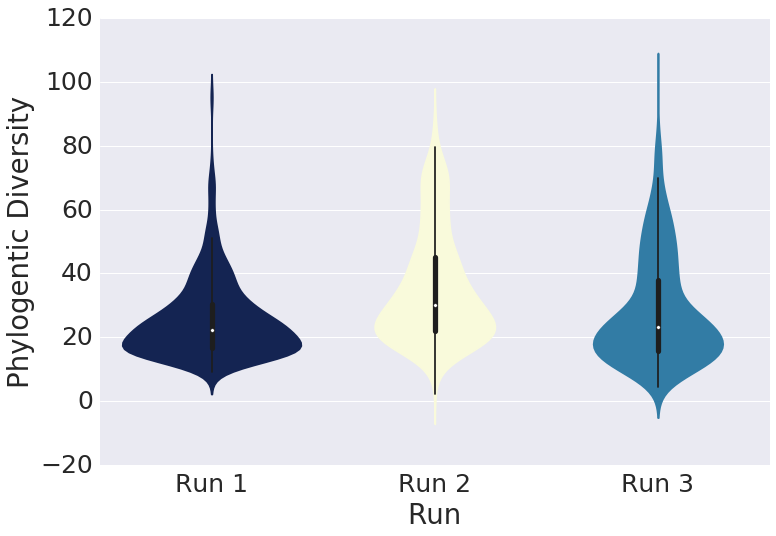

In [29]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    plt.figure(figsize=(12, 8))
    ax = sns.violinplot(x="Run", y="MeanAlpha", data=filt_md.sort("Run"), palette= [colors[e] for e in [99, 0, 66]])
    ax.set_xticklabels(['Run 1', 'Run 2', 'Run 3'])
    ax.set_ylabel('Phylogentic Diversity')
plt.savefig('all_samples_run_alpha.svg', dpi=300)

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


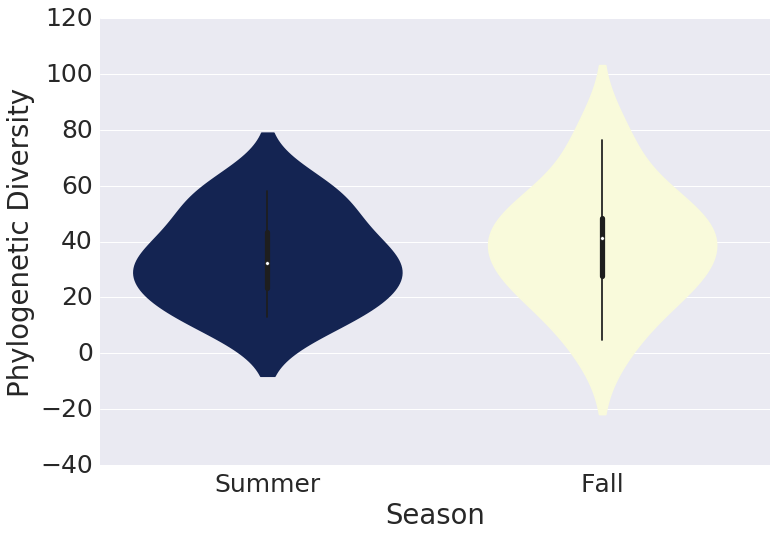

In [30]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    plt.figure(figsize=(12, 8))
    ax = sns.violinplot(x="Period", y="MeanAlpha", data=run_4_md.sort("Period"), palette= [colors[e] for e in [99, 0]])
    ax.set_xticklabels(['Summer', 'Fall'])
    ax.set_ylabel('Phylogenetic Diversity')
    ax.set_xlabel('Season')
plt.savefig('reps_samples_season_alpha.svg', dpi=300)


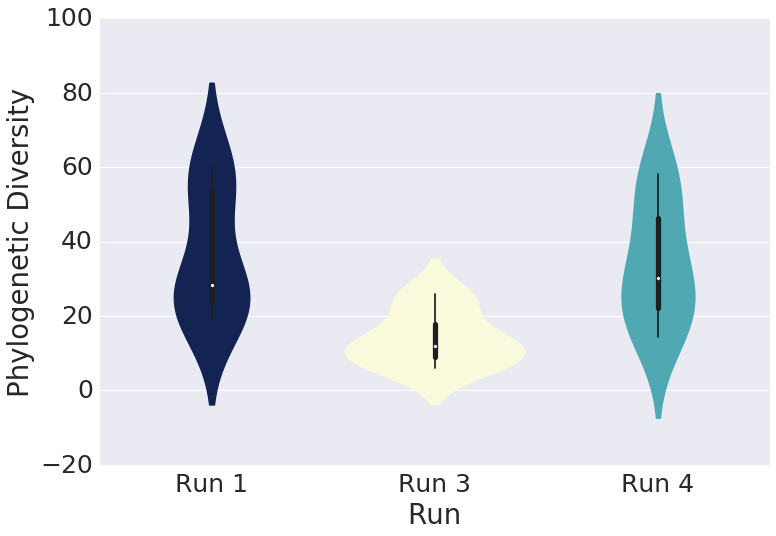

In [31]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    
    plt.figure(figsize=(12, 8))
    ax = sns.violinplot(x="Run", y="MeanAlpha", data=per_1_md.sort_values("Run"), palette= [colors[e] for e in [99, 0, 50]])
    ax.set_xticklabels(['Run 1', 'Run 3', 'Run 4'])
    ax.set_ylabel('Phylogenetic Diversity')
plt.savefig('reps_samples_run_alpha.svg', dpi=300)

#Permanova on replicates

In [32]:
uw_dm = skbio.DistanceMatrix.read(join(home, 'core_div_97/bdiv_even1000/unweighted_unifrac_dm.txt'))
w_dm = skbio.DistanceMatrix.read(join(home, 'core_div_97/bdiv_even1000/weighted_unifrac_dm.txt'))

In [33]:
run_md = per_1_md[per_1_md['Run'] != '4']
dm, run = filter_dm_and_map(uw_dm, run_md)
permanova(dm, run, column='Run', permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      16
number of groups                  2
test statistic               2.1718
p-value                      0.0004
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [34]:
run_md = per_1_md[per_1_md['Run'] != '3']
dm, run = filter_dm_and_map(uw_dm, run_md)
permanova(dm, run, column='Run', permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      16
number of groups                  2
test statistic              1.35333
p-value                      0.0315
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [35]:
run_md = per_1_md[per_1_md['Run'] != '1']
dm, run = filter_dm_and_map(uw_dm, run_md)
permanova(dm, run, column='Run', permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      16
number of groups                  2
test statistic              1.66969
p-value                      0.0035
number of permutations         9999
Name: PERMANOVA results, dtype: object